# Table of Contents
 <p>

In [287]:
# system("wget ftp://ftp.sanger.ac.uk/pub/gencode/Gencode_human/release_25/gencode.v25.annotation.gff3.gz")

In [288]:
require("dplyr", warn.conflicts = F, quietly = T)   # manipulation de données tabulaires
require("readr", warn.conflicts = F, quietly = T)   # parseur de fichiers texte
require("broom", warn.conflicts = F, quietly = T)   # nettoie après que R ait tout salit
require("cowplot", warn.conflicts = F, quietly = T) # figures multi-panaux, inclus ggplot2
require("svglite", warn.conflicts = F, quietly = T) # pour exporter les figures en svg
require("rtracklayer", warn.conflicts = F, quietly = T)  # parseur, notamment de fichiers GFF
require("data.table", warn.conflicts = F, quietly = T)  # manipulation de données tabulaires

In [289]:
### this is to prevent bug with data.table output ###
repr_html.data.table <- function(obj, ...) if (data.table::shouldPrint(obj)) NextMethod()
repr_latex.data.table <- function(obj, ...) if (data.table::shouldPrint(obj)) NextMethod()
repr_text.data.table <- function(obj, ...) if (data.table::shouldPrint(obj)) NextMethod()

In [ ]:
compiler::enableJIT(3) # Invocation de magie noire pour que R tourne plus vite
compiler::setCompilerOptions(suppressAll = TRUE) # Cachons la magie noir dans le... noir.
 
library(dplyr)
library(readr)
library(broom)
library(rtracklayer)
library(cowplot)
library(svglite)

library(data.table)
 
# l'import peu prendre 5 minutes en fonction de votre configuration
# notez qu'on importe directement la version compressé .gz
gencode <- import.gff3("gencode.v25.annotation.gff3.gz", format = "GFF") %>%
    # import() retoune un objet GRanges, nous le convertissons en data_frame
    as_data_frame

[1] 0

Note: no visible binding for global variable 'nframe' 
Note: no visible global function definition for 'send_error_msg' 
Note: no visible global function definition for 'is_silent' 
Note: no visible global function definition for 'send_response' 
Note: no visible binding for global variable 'current_request' 


In [3]:
saveRDS(gencode, "gencode.v25.RDS")

In [290]:
gencode <- readRDS("gencode.v25.RDS")

In [291]:
setDT(gencode)
object.size(gencode)
dim(gencode)
head(gencode, 3)

1609892024 bytes

[1] 2577236      29

seqnames,start,end,width,strand,source,type,score,phase,ID,⋯,transcript_status,transcript_name,transcript_support_level,tag,havana_transcript,exon_number,exon_id,ont,protein_id,ccdsid
chr1,11869,14409,2541,+,HAVANA,gene,NA,NA,ENSG00000223972.5,⋯,NA,NA,NA,,NA,NA,NA,,NA,NA
chr1,11869,14409,2541,+,HAVANA,transcript,NA,NA,ENST00000456328.2,⋯,KNOWN,DDX11L1-002,1,basic,OTTHUMT00000362751.1,NA,NA,,NA,NA
chr1,11869,12227,359,+,HAVANA,exon,NA,NA,exon:ENST00000456328.2:1,⋯,KNOWN,DDX11L1-002,1,basic,OTTHUMT00000362751.1,1,ENSE00002234944.1,,NA,NA


In [292]:
ptm <- proc.time()
proc.time() - ptm

   user  system elapsed 
  0.000   0.000   0.001 

   user  system elapsed 
  7.380   0.120   7.508 

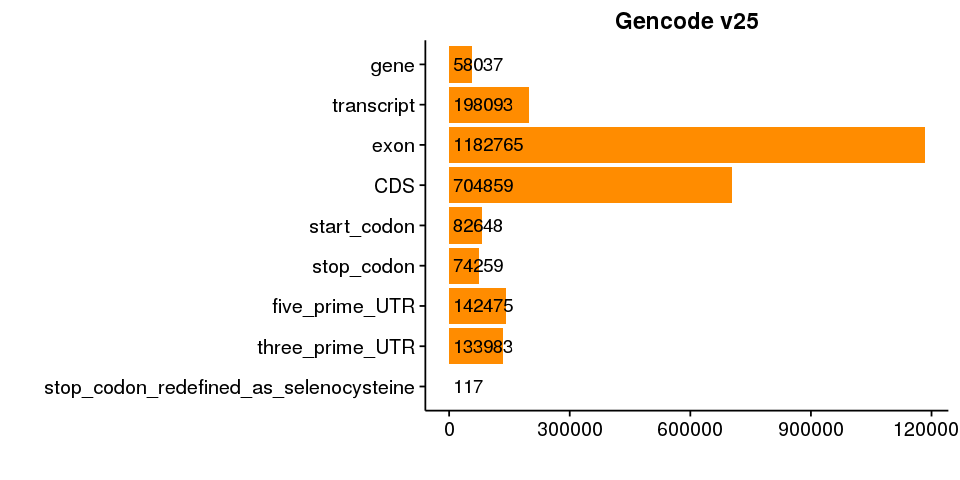

In [293]:
ptm <- proc.time()

fig1 <- ggplot(gencode, aes(x = factor(type, levels = rev(unique(type))))) +
    geom_bar(fill = "darkorange") +
    # affichons l’effectif sur chaque bar, avec le mot magique de ggplot2 ..count..
    geom_text(aes(label = ..count..), y = 10000, hjust = 0, stat = "count") +
    labs(x = "", y = "", title = "Gencode v25") +
    # renversons les axes
    coord_flip()

options(repr.plot.width=8, repr.plot.height=4)
fig1

proc.time() - ptm

In [294]:
ptm.begin <- proc.time()

   user  system elapsed 
 11.432   0.212   0.792 

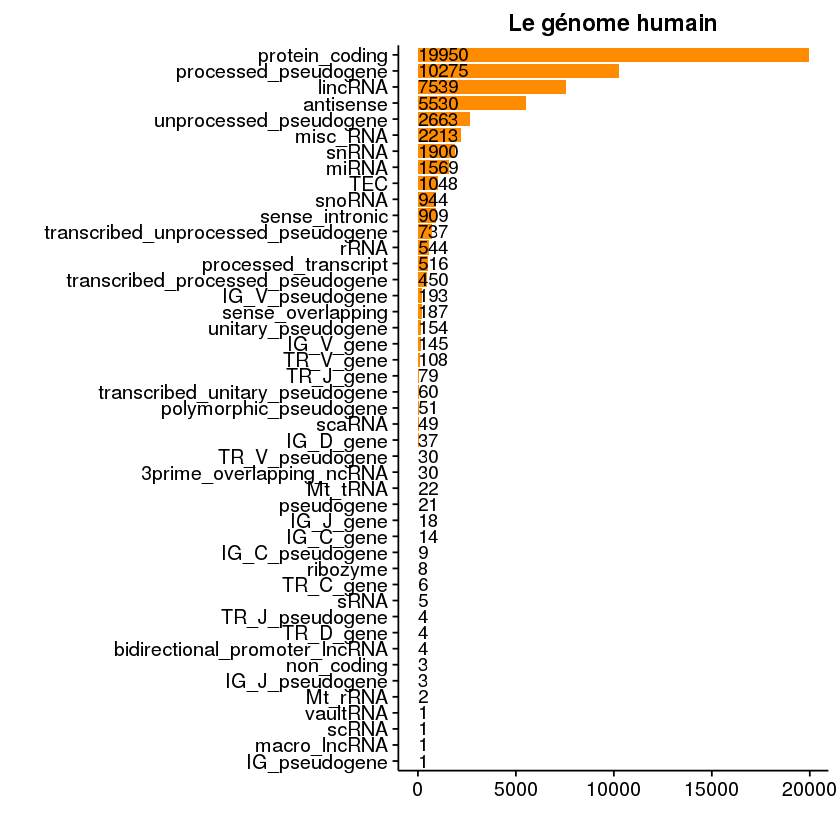

In [295]:
ptm <- proc.time()
setkey(gencode, type)
# trions les types de gènes en fonction de leur effectif
fig2 <- ggplot(gencode[.("gene")], aes(x = factor(
        gene_type,
        levels = names(sort(table(gene_type)))
    ))) +
    geom_bar(stat = "count", fill = "darkorange") +
    geom_text(aes(label = ..count..), y = 10, hjust = 0, stat = "count") +
    labs(x = "", y = "", title = "Le génome humain") +
    coord_flip()

options(repr.plot.width=7, repr.plot.height=7)
fig2
proc.time() - ptm

In [296]:
ptm <- proc.time()
gencode <- copy(gencode.tmp)
setDT(gencode)
setkey(gencode, type)


gencode[,simple_gene_type := gene_type]
setkey(gencode, type, simple_gene_type)

# si il y a pseudogene dans le nom, c'est un pseudogène
gencode[simple_gene_type %like% "pseudogene", simple_gene_type := "pseudogène"]
# si il y a ARN dans le nom,  c'est un gène ARN
gencode[simple_gene_type %like% "RNA", simple_gene_type := "gène ARN"]
# si c'est un autre type de gène, c'est un autre type de gène
gencode[!(simple_gene_type %in% c("protein_coding", "pseudogène", "gène ARN")), simple_gene_type := "autre"]
# en Français, c'est plus jolie
gencode[simple_gene_type == "protein_coding", simple_gene_type := "gène protéique"]
# trions par effectif, ça simplifiera le code des figures

gencode[, simple_gene_type := factor(simple_gene_type, 
                                     levels = names(sort(table(simple_gene_type), decreasing = TRUE))
                                    )]

proc.time() - ptm

   user  system elapsed 
 21.372   0.276   6.056 

   user  system elapsed 
  0.332   0.000   0.331 

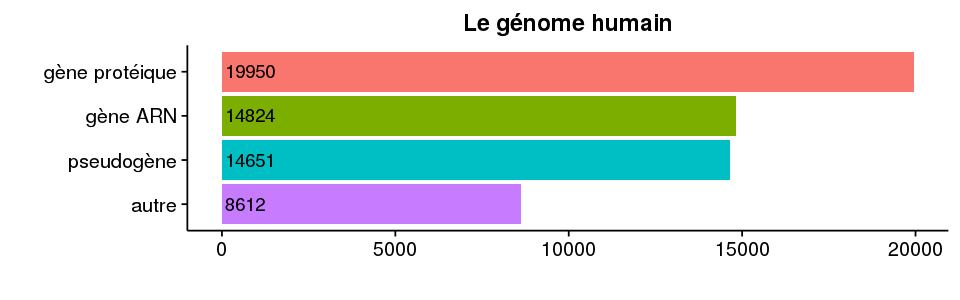

In [297]:
ptm <- proc.time()
fig3 <- ggplot(gencode[type == "gene"],
               aes(x = factor(simple_gene_type, levels = rev(levels(simple_gene_type))), fill = simple_gene_type)) +
    geom_bar(stat = "count") +
    geom_text(aes(label = ..count..), y = 100, hjust = 0, stat = "count") +
    labs(x = "", y = "", title = "Le génome humain") +
    coord_flip() +
    theme(legend.position="none")

options(repr.plot.width=8, repr.plot.height=2.5)
fig3
proc.time() - ptm

   user  system elapsed 
  0.320   0.000   0.318 

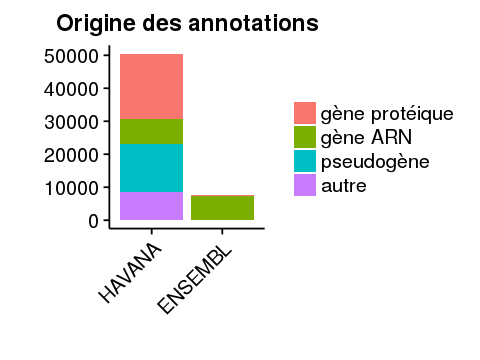

In [298]:
ptm <- proc.time()
fig4 <- ggplot(gencode[type == "gene"], aes(x = source, fill = simple_gene_type)) +
    geom_bar(stat = "count") +
    labs(x = "", y = "", title = "Origine des annotations", fill = "") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

options(repr.plot.width=4, repr.plot.height=3)
fig4
proc.time() - ptm

In [299]:
ptm <- proc.time()
genes_by_chr <- gencode[type == "gene", .(Freq = .N), by = .(seqnames, simple_gene_type)]
fig5A <- ggplot(genes_by_chr, 
    aes(x = seqnames, y = Freq, fill = simple_gene_type)) + 
    
    # pour une fois, on ne veut pas stat = 'count'
    geom_bar(stat = "identity") + labs(x = "", y = "", title = "Gènes par chromosomes") + 
    theme(legend.position = "none", axis.text.x = element_text(angle = 90, hjust = 0, 
        vjust = 0.5))
proc.time() - ptm

   user  system elapsed 
  0.016   0.000   0.013 

In [300]:
ptm <- proc.time()
# lecture du fichier texte directement depuis le serveur (fread est plus rapide que read csv)
chr_length <- fread("http://hgdownload-test.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes", col.names = c("seqnames", "length"))
chr_length <- chr_length[seqnames %in% c(paste0("chr", 1:22), "chrX", "chrY", "chrM")]
chr_length[, seqnames := factor(seqnames, levels = c(paste0("chr", 1:22), "chrX", "chrY", "chrM"))]

fig5B <- ggplot(chr_length, aes(x = seqnames, y = length)) +
    geom_bar(stat = "identity", fill = "darkorange") +
    labs(x = "", y = "", title = "Taille des chromosomes (pb)") +
    theme(axis.text.x = element_text(angle = 90, hjust = 0, vjust = 0.5))
proc.time() - ptm

   user  system elapsed 
  0.028   0.004   0.374 

In [301]:
ptm <- proc.time()
# fusion des deux tableau grâce a dplyr::left_join
setDT(genes_by_chr)
setkey(genes_by_chr, seqnames)
setDT(chr_length)

genes_by_chr[chr_length, perMb := Freq * 1E6 / length]
 
fig5C <- ggplot(genes_by_chr, aes(x = seqnames, y = perMb, fill = simple_gene_type)) +
    geom_bar(stat = "identity") +
    coord_cartesian(ylim = c(0, 25)) +
    # une facette par type de gènes
    facet_wrap(~simple_gene_type, ncol = 1) +
    labs(x = "", y = "", title = "Gènes par mégabase par chromosomes") +
    theme(legend.position = "none", axis.text.x = element_text(angle = 90, hjust = 0, vjust = 0.5))
 proc.time() - ptm

   user  system elapsed 
  0.064   0.000   0.025 

   user  system elapsed 
  1.508   0.016   1.089 

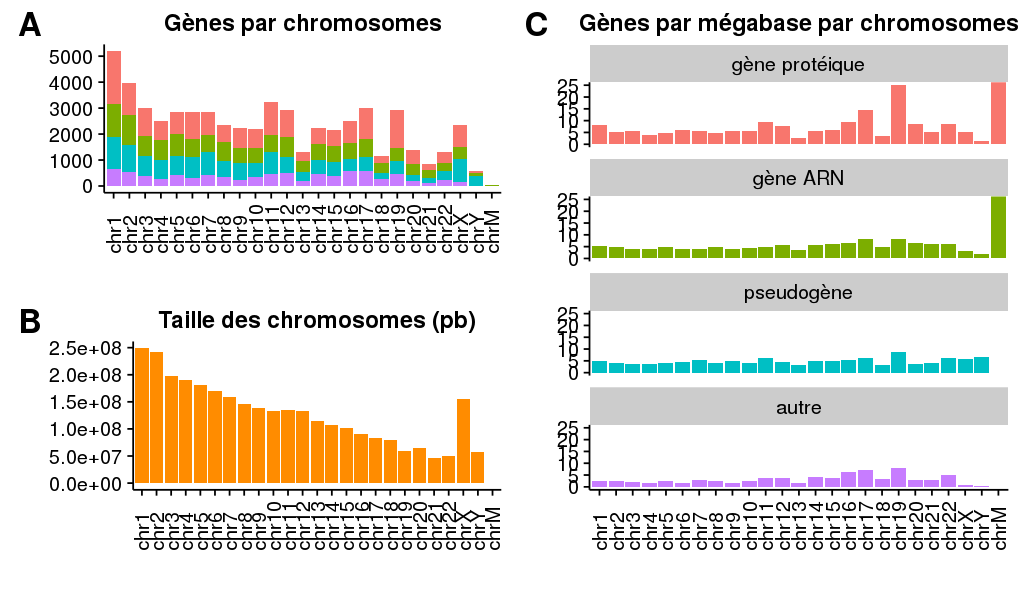

In [302]:
ptm <- proc.time()
# assemblage des panneaux avec cowplot
# la zone fait 1 x 1, avec le point (0,0) en bas à gauche
fig5 <- ggdraw() +
    draw_plot(fig5A, x = 0  , y = 0.5, w = 0.5, h = 0.5) +
    draw_plot(fig5B, x = 0  , y = 0  , w = 0.5, h = 0.5) +
    draw_plot(fig5C, x = 0.5, y = 0  , w = 0.5, h = 1  ) +
    draw_plot_label(c("A", "B", "C"), c(0, 0, 0.5), c(1, 0.5, 1), size = 20)

options(repr.plot.width=8.5, repr.plot.height=5)
fig5

proc.time() - ptm

In [303]:
ptm <-  proc.time()
fig6A <- ggplot(
    gencode[type == "transcript", 
            .(n_transcript = min(.N, 20)), 
            by = .(gene_id, simple_gene_type)],
    
    aes(x = n_transcript, fill = simple_gene_type)) +
    geom_bar() + 
    scale_x_continuous(breaks = c(1, 10, 20), labels = c(1, 10, "≥ 20")) + 
    facet_wrap(~simple_gene_type, scales = "free_y", ncol = 1) + 
    theme(legend.position = "none") + 
    labs(x = "Nombre de\ntranscrits", y = "Nombre de gènes", title = "Transcrits\npar gènes")
 proc.time() - ptm

   user  system elapsed 
  0.080   0.000   0.077 

In [304]:
ptm <- proc.time()
gencode[, exon_number := as.integer(exon_number)]
fig6B <- ggplot(
    gencode[type == "exon", .(n_exon = min(c(max(exon_number), 20L))), by = .(gene_id, simple_gene_type)],
    
    aes(x = n_exon, fill = simple_gene_type)) +
    geom_bar() +
    scale_x_continuous(breaks = c(1, 10, 20), labels = c(1, 10, "\u2265 20")) +
    facet_wrap(~simple_gene_type, scales = "free_y", ncol = 1) +
    theme(legend.position = "none") +
    labs(x = "Nombre\nd'exons", y = "Nombre de gènes", title = "Exons\npar gènes")
 proc.time() - ptm

   user  system elapsed 
  0.412   0.000   0.413 

In [305]:
ptm <-  proc.time()

gencode[,gene_version := sub(".+\\.", "", gene_id)]
gencode[,gene_version := as.integer(gene_version)]
gencode[gene_version > 20, gene_version := 20L]

fig6C <- ggplot(gencode[type == "gene"], aes(x = gene_version, fill = simple_gene_type)) +
    geom_bar() +
    scale_x_continuous(breaks = c(1, 10, 20), labels = c(1, 10, "\u2265 20")) +
    facet_wrap(~simple_gene_type, scales = "free_y", ncol = 1) +
    theme(legend.position = "none") +
    labs(x = "Nombre de\nrévisions", y = "Nombre de gènes", title = "Révisions\npar gènes")

proc.time() - ptm

   user  system elapsed 
  3.128   0.000   3.133 

In [306]:
# plot_grid est une version simplifié de ggdraw(), dans lequel les plots sont rangés dans une grille
fig6 <- plot_grid(fig6A, fig6B, fig6C, labels = LETTERS[1:3], ncol = 3, label_size = 20)

Warning message in grid.Call(L_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“erreur de conversion de '≥ 20' dans 'mbcsToSbcs' : le point est substitué pour <e2>”Warning message in grid.Call(L_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“erreur de conversion de '≥ 20' dans 'mbcsToSbcs' : le point est substitué pour <89>”Warning message in grid.Call(L_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“erreur de conversion de '≥ 20' dans 'mbcsToSbcs' : le point est substitué pour <a5>”Warning message in grid.Call(L_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“erreur de conversion de '≥ 20' dans 'mbcsToSbcs' : le point est substitué pour <e2>”Warning message in grid.Call(L_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“erreur de conversion de '≥ 20' dans 'mbcsToSbcs' : le point est substitué pour <89>”Warning message in grid.Call(L_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“erreur de conversion de '≥ 20' dans 'mbcsToSbcs' : le point est substitué pour <a5

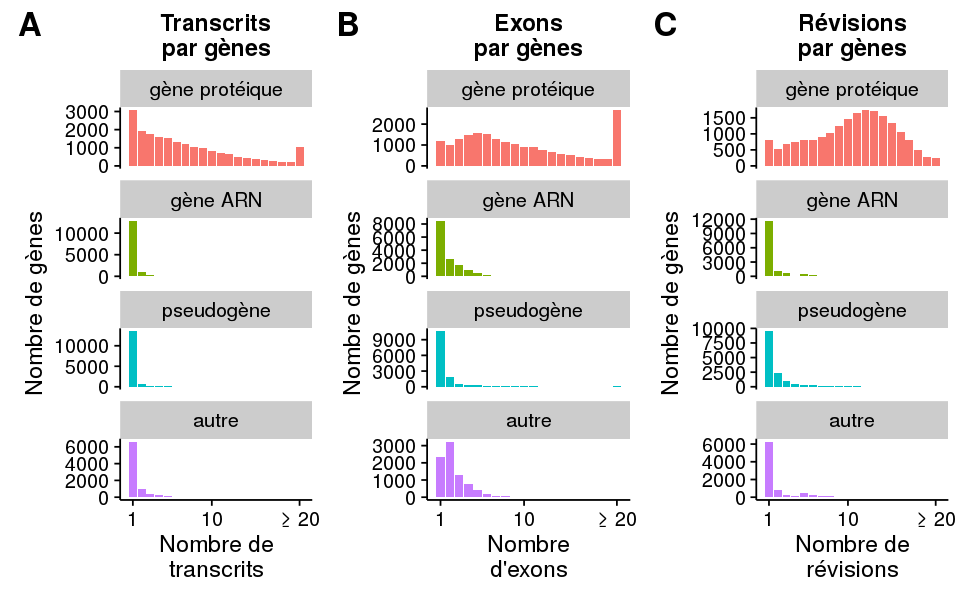

In [307]:
options(repr.plot.width=8, repr.plot.height=5)
fig6

In [308]:
ptm <- proc.time()
# la longueur exons + introns est triviale à obtenir grâce à la colonne width
fig7A <- ggplot(gencode[type == "gene"],
            aes(x = width, fill = simple_gene_type, color = simple_gene_type)) +
            # geom_denisty plot la distribution des longueurs
            geom_density(alpha = 0.2) +
            # on fixe la même échelle pour tout les plots
            scale_x_log10(limits = c(10, 10000000)) +
            annotation_logticks(sides = "b") +
            labs(x = "Paire de bases", y = "Densité", title = "Longueur des gènes (exons + introns)", fill = "", color = "")

proc.time() - ptm

   user  system elapsed 
  0.028   0.000   0.027 

In [309]:
ptm <- proc.time()
# pour la longueur des transcrits, on somme tout les exons de chaque transcrits
fig7B <- ggplot(
    gencode[type == "exon",
            .(transcript_length = sum(width)),
            by = .(gene_id, transcript_id, simple_gene_type)
           ][,.(gene_length = median(transcript_length)),
             by = .(gene_id, simple_gene_type)
            ],
    aes(x = gene_length, fill = simple_gene_type, color = simple_gene_type)) +
    geom_density(alpha = 0.2) +
    scale_x_log10(limits = c(10, 10000000)) +
    annotation_logticks(sides = "b") +
    labs(x = "Paire de bases", y = "Densité", title = "Longueur des gènes (exons seuls)", fill = "", color = "")

proc.time() - ptm 

   user  system elapsed 
  0.152   0.000   0.151 

In [310]:
ptm <- proc.time()

# la longueur des exons est triviale à obtenir
fig7C <- ggplot(gencode[type == "exon"], aes(x = width, fill = simple_gene_type, color = simple_gene_type)) +
    geom_density(alpha = 0.2) +
    scale_x_log10(limits = c(10, 10000000)) +
    annotation_logticks(sides = "b") +
    labs(x = "Paire de bases", y = "Densité", title = "Longueur des exons", fill = "", color = "")

proc.time() - ptm 

   user  system elapsed 
  0.296   0.000   0.293 

In [311]:
ptm <- proc.time()
setkey(gencode, start, gene_id, transcript_id, simple_gene_type)
gencode[type == "exon", next_exon_start := shift(start, 1, type='lead'), by = .(gene_id, transcript_id, simple_gene_type)]
gencode[type == "exon", intron_length := next_exon_start - end]

# pour la longueur des introns, il faut ruser !
fig7D <- ggplot(gencode[type == "exon"], 
    aes(x = intron_length, fill = simple_gene_type, color = simple_gene_type)) +
    geom_density(alpha = 0.2) +
    scale_x_log10(limits = c(10, 10000000)) +
    annotation_logticks(sides = "b") +
    labs(x = "Paire de bases", y = "Densité", title = "Longueur des introns", fill = "", color = "")

proc.time() - ptm 

   user  system elapsed 
 13.068   0.128   5.485 

In [312]:
fig7 <- plot_grid(fig7A, fig7B, fig7C, fig7D, labels = LETTERS[1:4], ncol = 1, label_size = 20)

Warning message:
“Removed 2 rows containing non-finite values (stat_density).”Warning message:
“Removed 2 rows containing non-finite values (stat_density).”Warning message:
“Removed 2141 rows containing non-finite values (stat_density).”Warning message in self$trans$transform(x):
“production de NaN”Warning message:
“Transformation introduced infinite values in continuous x-axis”Warning message:
“Removed 199480 rows containing non-finite values (stat_density).”

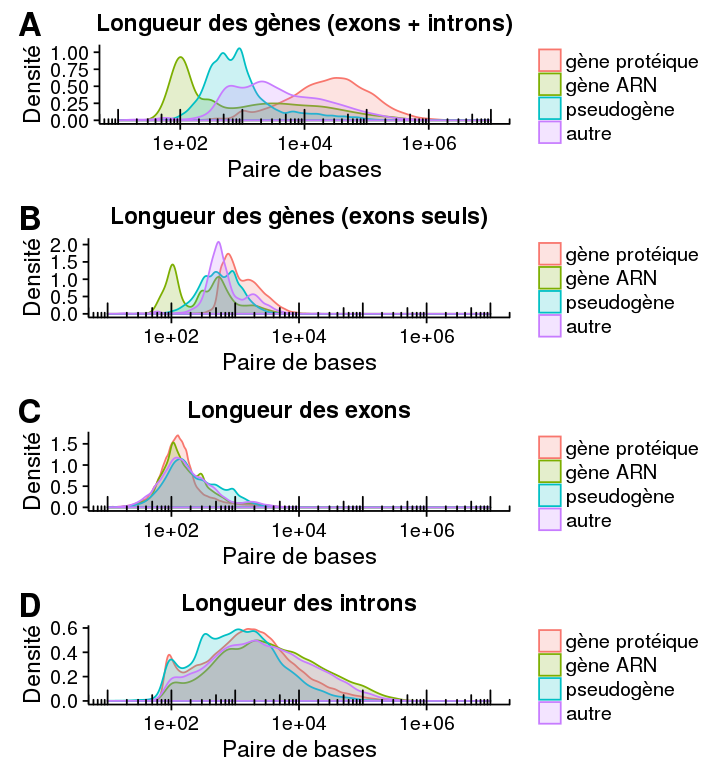

In [313]:
options(repr.plot.width=6, repr.plot.height=6.5)
fig7

In [314]:
# A ce stade de l'article, vous devriez commencer à saisir la démarche:
# on ne garde que les lignes de type "CDS"
ptm <- proc.time()

fig8A <- ggplot(gencode[type == "CDS", .(modulo_3 = width %% 3)], aes(x = modulo_3)) +
    geom_bar(fill = "darkorange") +
    labs(x = "", y = "effectif", title = "Modulo 3 des\nCDS (exons)")

proc.time() - ptm 

   user  system elapsed 
  0.036   0.000   0.039 

In [315]:
ptm <- proc.time()
fig8B <- ggplot(
    gencode[
        type == "CDS", .(modulo_3 = sum(width) %% 3), by = .(gene_id, transcript_id)
    ][
        , .(modulo_3 = floor(median(modulo_3))), by = .(gene_id)
    ],
    aes(x = modulo_3)) +
    geom_bar(fill = "darkorange",) +
    labs(x = "", y = "effectif", title = "Modulo 3 des\nCDS (gènes)")
 

proc.time() - ptm 

   user  system elapsed 
  1.100   0.000   1.102 

In [316]:
fig8 <- plot_grid(fig8A, fig8B, labels = LETTERS[1:2], ncol = 2, label_size = 20)

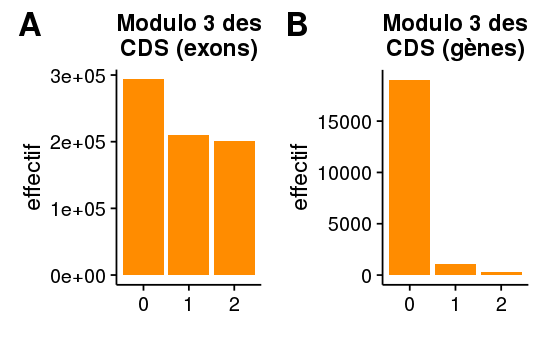

In [317]:
options(repr.plot.width=4.5, repr.plot.height=3)
fig8

   user  system elapsed 
  2.624   0.004   2.628 

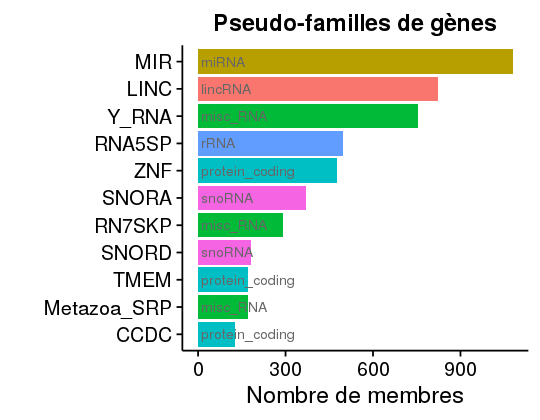

In [318]:
ptm <- proc.time()

gencode[type == "gene", family_name := sub("[0-9]*$", "", gene_name), by = .(gene_type)]
gencode[type == "gene", family_count := .N, by = .(gene_type, family_name)]

fig9 <-  ggplot(gencode[type == "gene", .(family_count = unique(family_count)), by = .(gene_type, family_name)][family_count >= 100][order(family_count)],
    aes(x = factor(family_name, levels = family_name), y = family_count, fill = gene_type)) +
    geom_bar(stat = "identity") +
    geom_text(aes(label = gene_type, y = 10), hjust = 0, color = "grey40", size = 3) +
    coord_flip() +
    labs(x = "", y = "Nombre de membres", title = "Pseudo-familles de gènes") +
    theme(legend.position = "none")

options(repr.plot.width=4.5, repr.plot.height=3.5)
fig9

proc.time() - ptm 

In [319]:
proc.time() - ptm.begin

   user  system elapsed 
 67.668   0.684  34.013 